# Check out how the channel might meander from the old radarlines to new

Interpolation of old and new radarline comes from 26_RADAR_interpolate_line2line_by_distance_downchan


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [21]:
new_gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')
old_gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/1516_gprlines.shp')
old_gpr['camp'] = 'KIS2' 
bed_gdf = pd.concat([new_gpr,old_gpr])
gdf = bed_gdf[bed_gdf.camp =='KIS2'].copy()
ngpr = new_gpr[new_gpr.camp =='KIS2'].copy()

In [22]:
x_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydistold_points_x.npy')
y_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydistold_points_y.npy')
it_old = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydistold_ice_thickn.npy')

In [23]:
x_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_x.npy')
y_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_y.npy')
it_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_ice_thickn.npy')

In [24]:
#load REMA
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Users/home/whitefar/DATA/REMOTE_SENSING/REMA_2m_strips/REMA_Strip_Index_Rel1.shp')
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
with rio.open(path) as image:
    im = image.read(1)
    im[im==-9999] = np.nan
    im = im / duration
    extent_REMAdiff = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)/100

In [25]:
df.loc[nid1].fileurl

'http://data.pgc.umn.edu/elev/dem/setsm/REMA/geocell/v1.0/2m/s83w153/SETSM_WV02_20121224_103001001D86CA00_103001001D886000_seg1_2m_v1.0.tar.gz'

In [26]:
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
extent_l2l = np.load(direc +'extent.npy')
surf_out = np.load(direc +'surface.npy')

In [27]:
x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

In [28]:
xmin, xmax, ymin, ymax = extent_l2l

In [29]:
x_i = np.argwhere((x>xmin) & (x< xmax)).flatten()[0]
x_j = np.argwhere((x>xmin) & (x< xmax)).flatten()[-1]
y_i = np.argwhere((y>ymin) & (y< ymax)).flatten()[0]
y_j = np.argwhere((y>ymin) & (y< ymax)).flatten()[-1]

In [11]:
x_c = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')[x_i:x_j]
y_c = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')[y_i:y_j]

In [12]:
xv_REMA, yv_REMA = np.meshgrid(x_c, y_c)Evening Run

In [13]:
im_REMA_d = im_REMA[y_i:y_j,x_i:x_j]
im_REMA_d[im_REMA_d==-99.99] = np.nan
im_REMA_c = im_REMA_d*100
del im_REMA_d

## 1. REMA bullseye with contours of channel

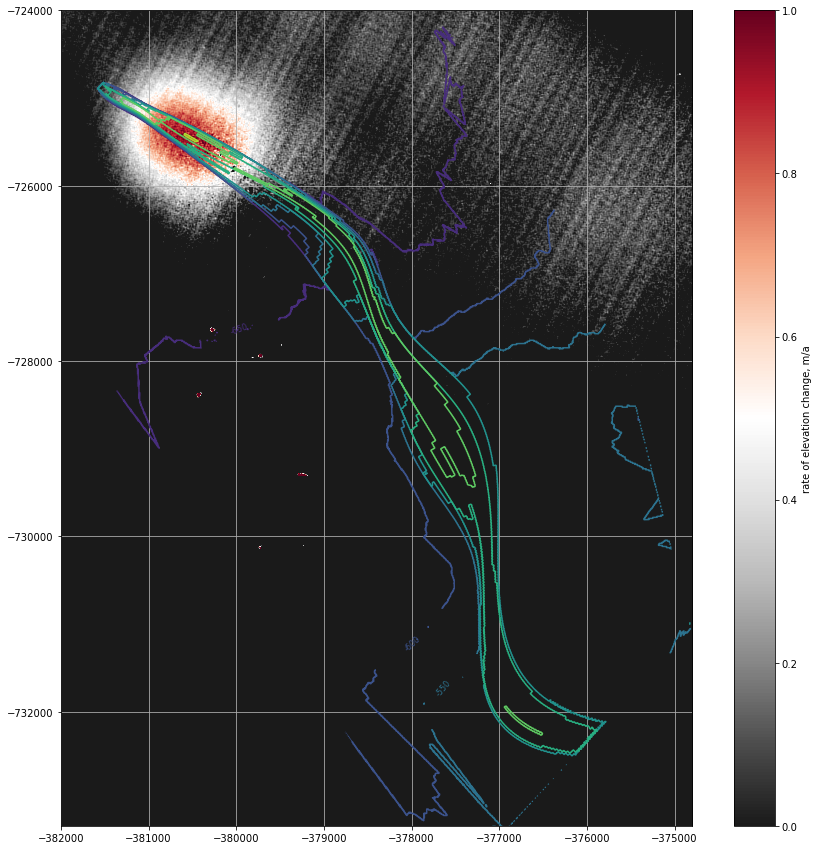

In [15]:

# %matplotlib qt
#rema
v=[0,1]    

extent_REMA1 = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
plt.figure(figsize=(15,15))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent_REMAdiff, vmin=v[0],vmax=v[1],cmap=GyRd)
cb = plt.colorbar()
cb.set_label('rate of elevation change, m/a')

# manual_locations = [(-380000, -727585),(-378000, -731200), (-380250,727650), (-377116, -729519), (-377640, -731742),  (-377470,-728870), (2.4, 1.7)]
manual_locations = [(-380000, -727585),(-378000, -731200),(-377640, -731742)]

CS = plt.contour(xv,yv,surf_out-thickness_interpolated)
plt.clabel(CS, inline=1, fontsize=8, fmt='%i', manual=manual_locations)

plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/bullseye_n_basecontour.png')
# cb2 = plt.colorbar()
# cb2.set_label('Elevation of ice underside, m')
plt.xlim([-382000, -374800])
plt.ylim([-733300,-724000])
plt.grid()
plt.show()

## 2. colors of chan with contours of surf

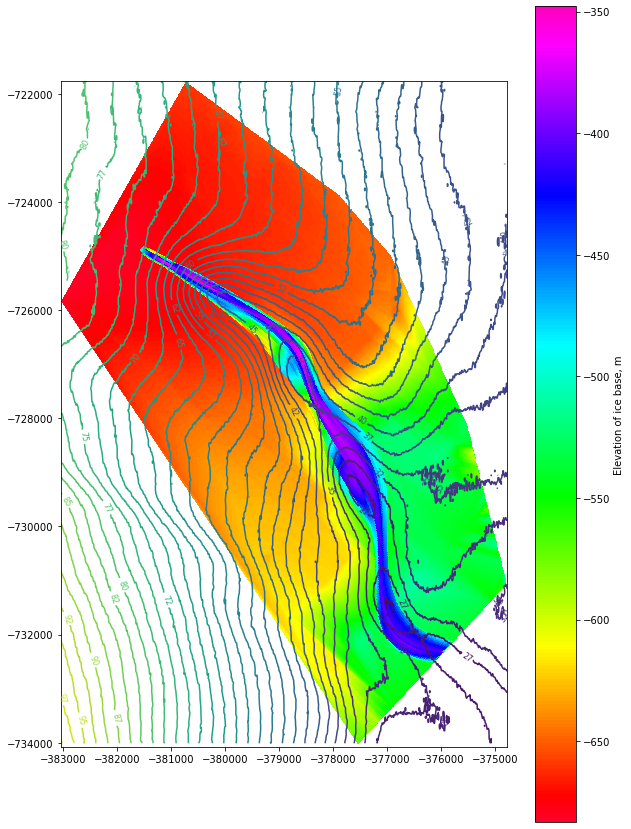

In [18]:
jj = 40

plt.figure(figsize=(10,15))

CS =  plt.contour(xv_REMA[::jj],yv_REMA[::jj],im_REMA_c[::jj],30)
plt.clabel(CS, inline=1, fontsize=8, fmt='%i')

v = [-750,-350]
plt.imshow(surf_out-thickness_interpolated,extent=extent_l2l,cmap='gist_rainbow')


cb = plt.colorbar()
cb.set_label('Elevation of ice base, m')
# plt.title('Colored base of ice with contours of surface topography')
plt.show()

## 3. thickness over length

In [7]:
it = it_new[10,:]
x = x_new[10,:]
y = y_new[10,:]
mid = pd.DataFrame({'x': x,'y':y,'ice_thickn':it})

points_mid = [Point(xy) for xy in zip(mid.x,mid.y)]
gdf_mid = gpd.GeoDataFrame(mid,geometry=points_mid,crs="EPSG:3031")

In [20]:
points_x = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_x_channel.npy')
points_y = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_y_channel.npy') 
ice_thickn= np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/ice_thickn_channel.npy')

In [34]:
%matplotlib qt
#  fug, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 3]},figsize=(6,6),dpi=180)#rema

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,gridspec_kw = {'width_ratios':[1, 4],'height_ratios':[1]},
                               figsize=(8,10),dpi=180)#rema ,constrained_layout=True
v=[0,1]    

kis2 = [-380737.537026,-724683.311299]

ax2.imshow(im_REMA,extent=extent_REMA,vmin=0.2,vmax=0.7, cmap='BrBG')
ax2.plot( gdf_mid.x,gdf_mid.y,label='interpolated channel')
ax2.plot( gdf_mid.x.iloc[39],gdf_mid.y.iloc[39],'b1',label="channel low",markersize=15,markeredgewidth=2)
ax2.plot(points_x[10,:],points_y[10,:],'x',label="19-20 surveyed points")
ax2.set_xlim([-382000, -374800])
ax2.set_ylim([-733300,-724000])
ax2.grid()
ax2.set_xlabel('X, UTM')
ax2.legend()
# plt.contour(xv,yv,surf_out-thickness_interpolated,linewidths=0.75)


ax1.plot(gdf_mid.ice_thickn,gdf_mid.y)
ax1.plot(ice_thickn[10,:],points_y[10,:],'x',label="19-20 surveyed points")
ax1.plot( gdf_mid.ice_thickn.iloc[39],gdf_mid.y.iloc[39],'b1',label="channel low",markersize=15,markeredgewidth=2)
# ax1.set_xlim([400, 480])
ax1.set_ylim([-733300,-724000])
ax1.set_ylabel('Y, UTM')
ax1.set_xlabel('ice thickness, m')

ax1.grid()
fig.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/thickness_surfacecolour.png')
fig.show()



# find out width of channel surf and bed

In [6]:
new_gpr.keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'SEQnum', 'camp',
       'time_UTC', 'ice_thickn', 'bed', 'geometry'],
      dtype='object')

In [5]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2, ie one gdf for each line.

for line in new_gpr[new_gpr.camp =='KIS2'].line_name.unique().tolist():
    ll[line] = new_gpr[(new_gpr.line_name==line) & (new_gpr.camp=='KIS2')].copy()
    ll[line].sort_values(by='x',inplace=True)
    ll[line].reset_index(drop=True,inplace=True)

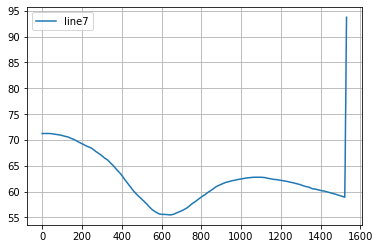

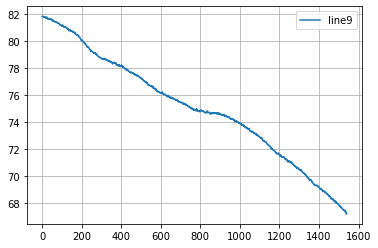

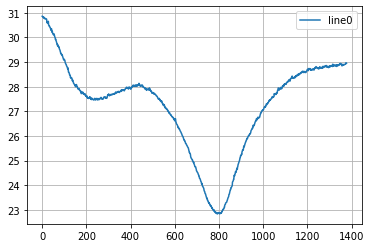

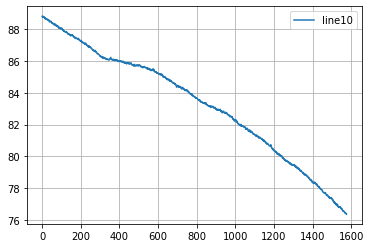

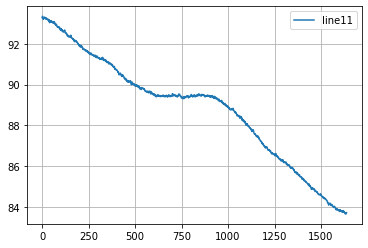

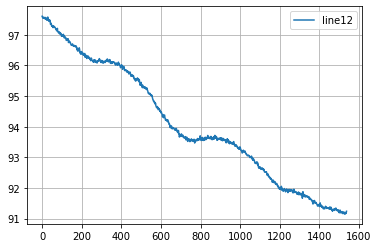

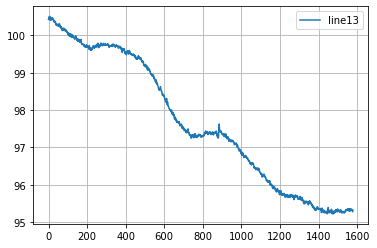

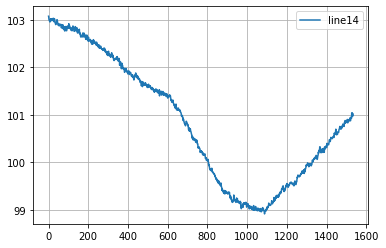

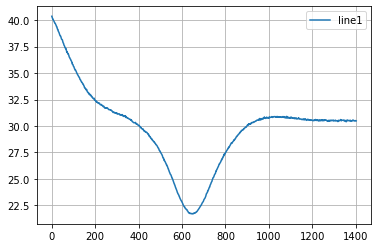

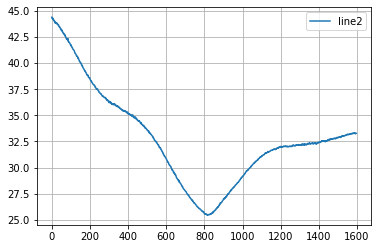

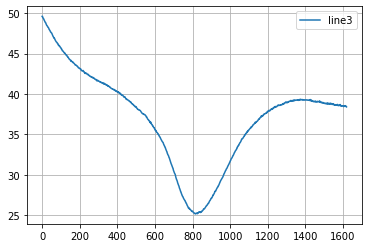

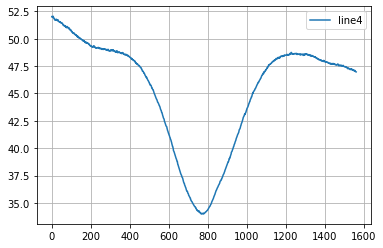

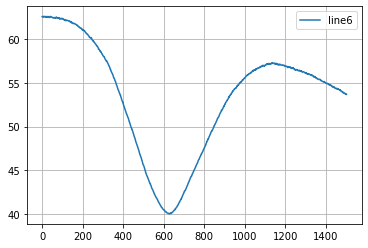

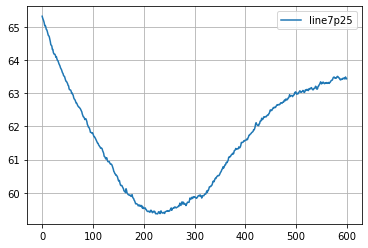

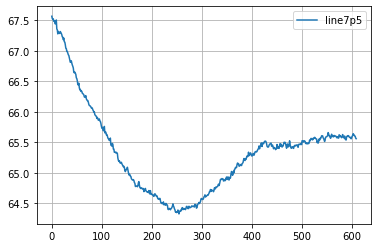

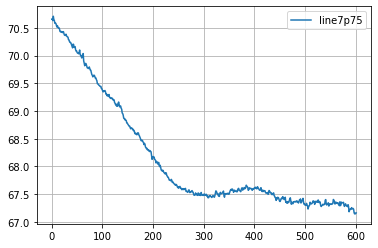

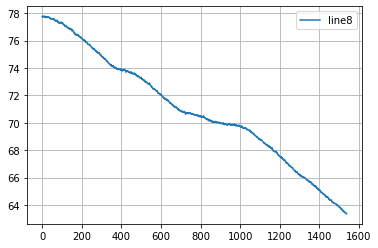

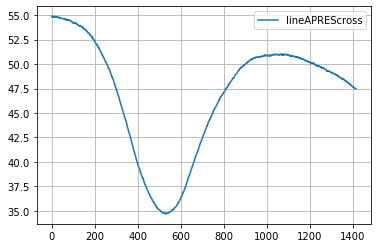

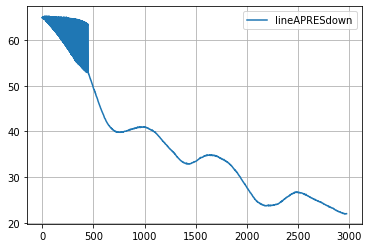

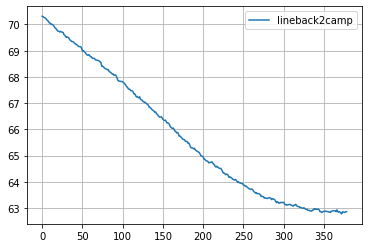

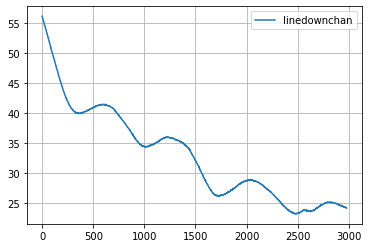

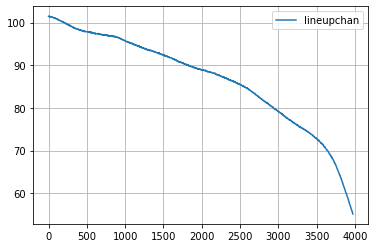

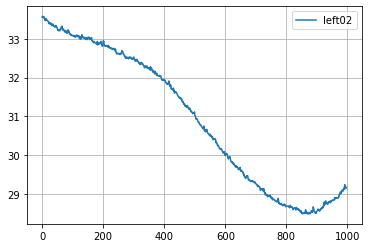

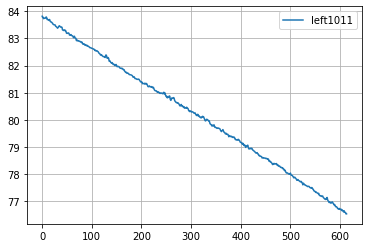

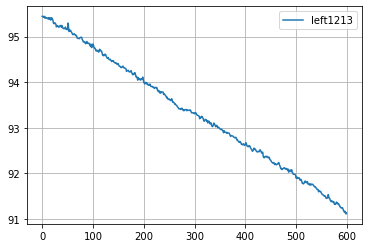

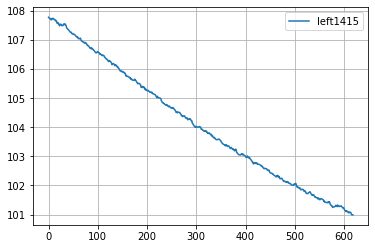

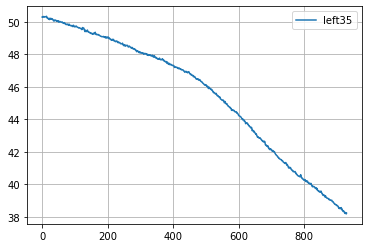

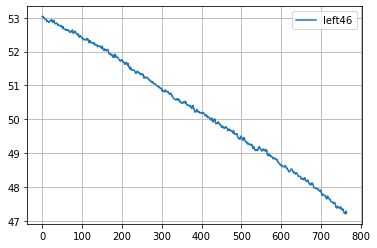

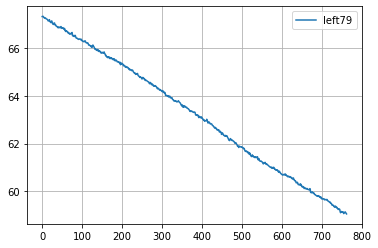

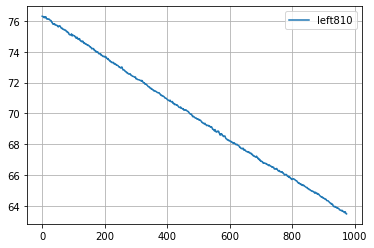

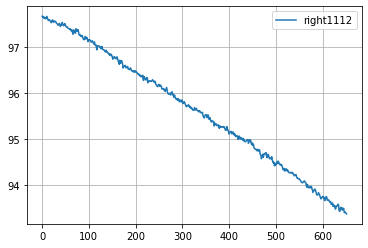

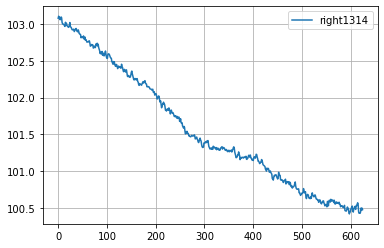

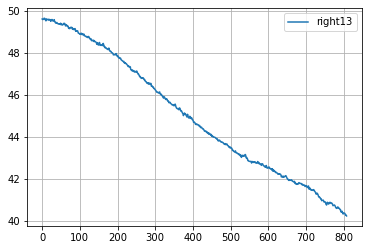

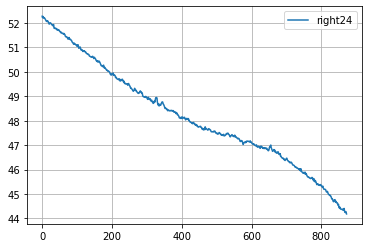

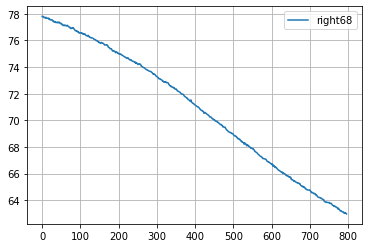

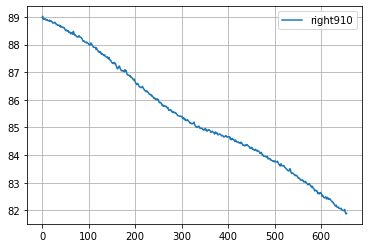

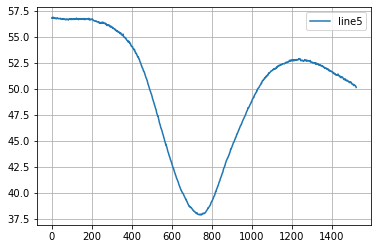

In [36]:
for line_name,line in ll.items():
    plt.plot(line.surf,label=line_name)
    plt.legend()
    plt.grid()
    plt.show()

In [39]:
width_0 = ll['line7'].loc[0].geometry.distance(ll['line7'].loc[1000].geometry)
width_6 = ll['line6'].loc[100].geometry.distance(ll['line6'].loc[1100].geometry)
width_0 = ll['line0'].loc[450].geometry.distance(ll['line0'].loc[1300].geometry)
print('width at line7 then 6 is about',width_0,width_6, width_0)

width at line7 then 6 is about 2549.5080094010377 2992.419410777798 2549.5080094010377


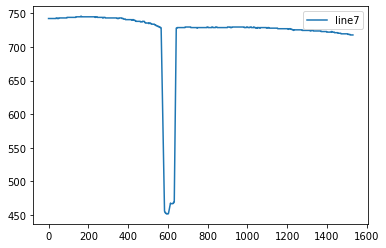

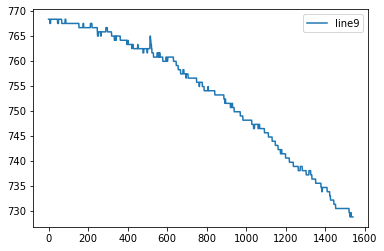

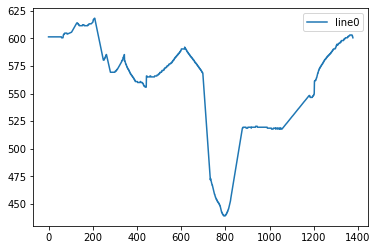

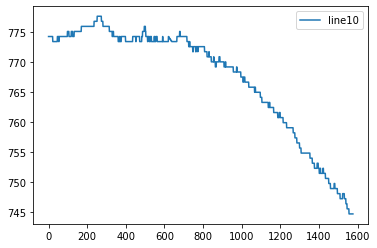

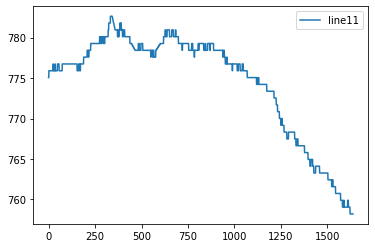

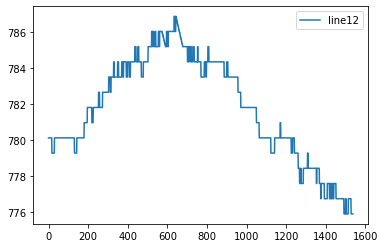

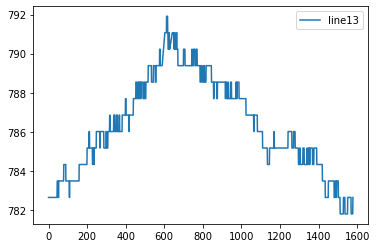

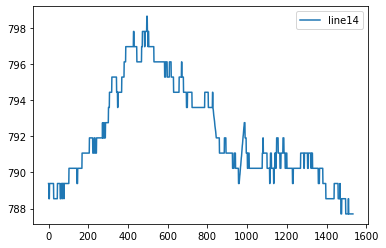

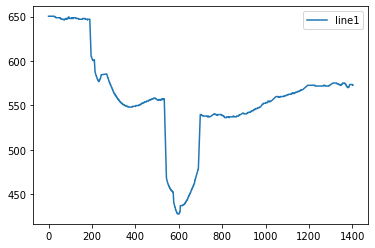

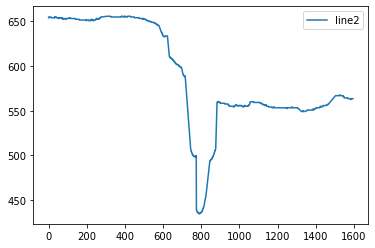

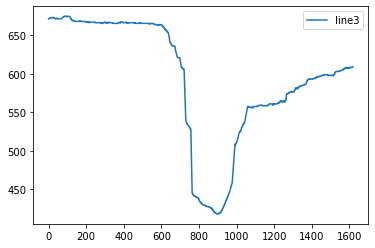

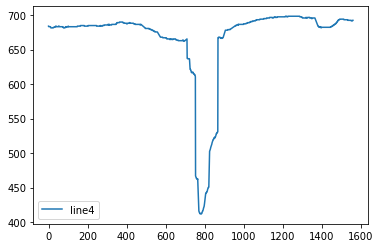

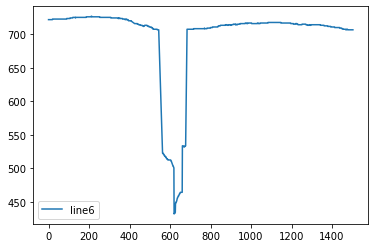

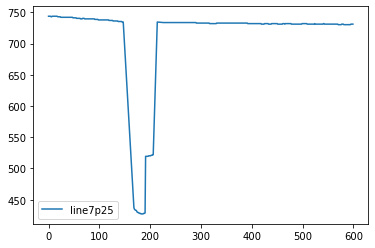

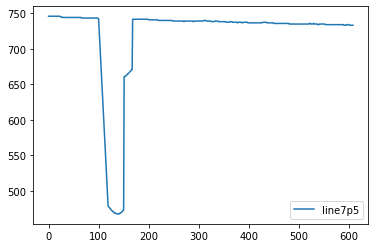

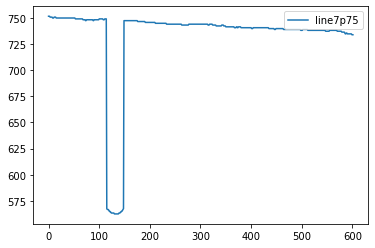

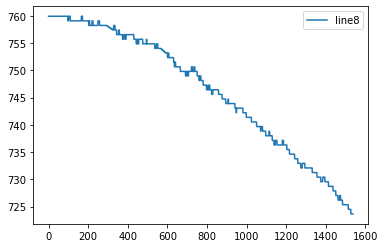

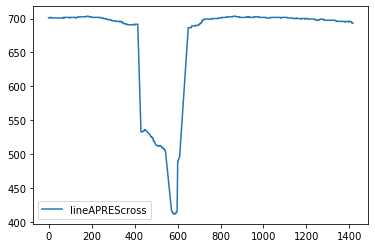

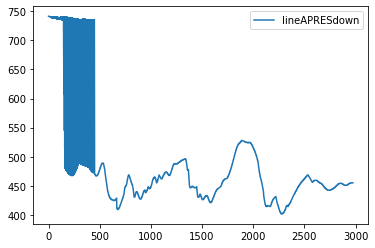

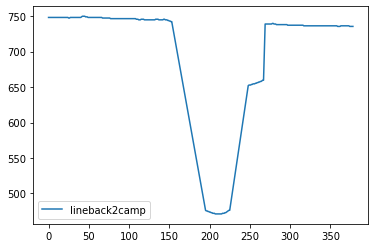

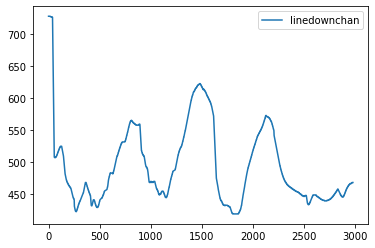

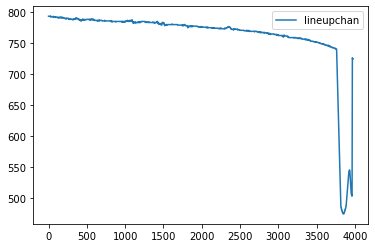

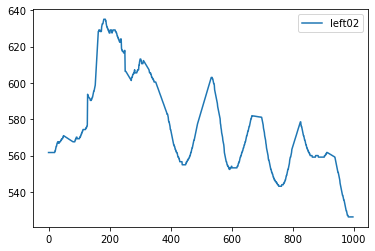

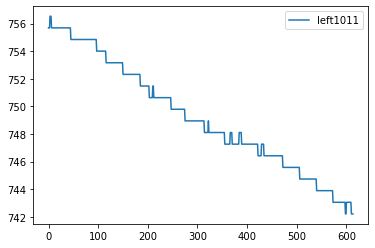

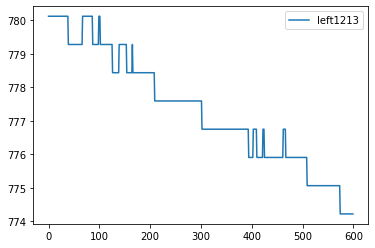

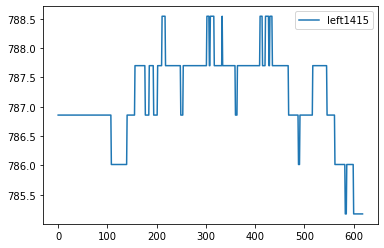

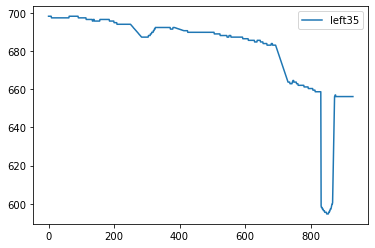

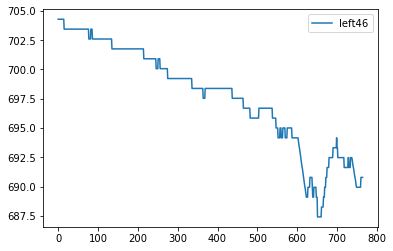

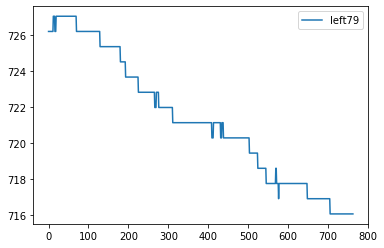

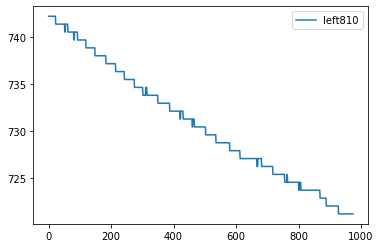

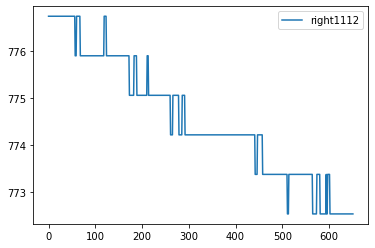

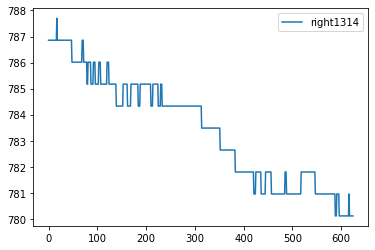

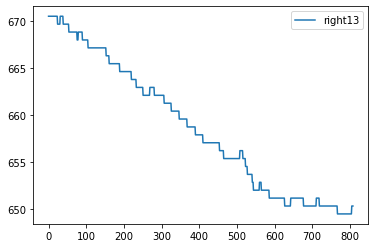

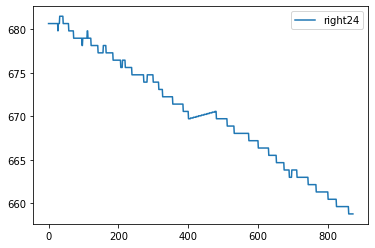

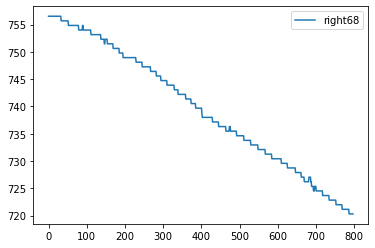

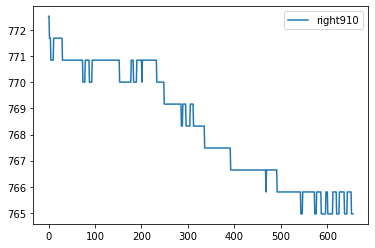

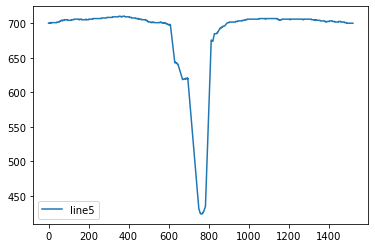

In [19]:
#depth of channel 100-300m
for line_name,line in ll.items():
    plt.plot(line.ice_thickn,label=line_name)
    plt.legend()
    plt.show()

In [32]:
#op = original points
ice_thickn_op = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/ice_thickn_channel.npy')
points_x_op = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_x_channel.npy')
points_y_op = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_y_channel.npy') 

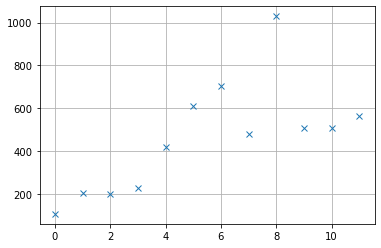

In [34]:
#width of channel
lhs =[Point(x,y) for x,y in zip(points_x_op[0,:],points_y_op[0,:])]
rhs=[Point(x,y) for x,y in zip(points_x_op[-1,:],points_y_op[-1,:])]
width = [l.distance(r) for l,r in zip(lhs,rhs)]
plt.plot(width,'x')
plt.grid()

In [23]:
x_new[0,:]

array([-381579.1       , -381562.11945716, -381543.82203319,
       -381524.30570977, -381503.6684686 , -381482.00829134,
       -381459.42315969, -381436.01105533, -381411.86995994,
       -381387.09785522, -381361.79272284, -381336.05254448,
       -381309.97530184, -381283.65897659, -381257.20155042,
       -381230.70100502, -381204.25532206, -381177.96248324,
       -381151.92047023, -381126.22385184, -381100.8938392 ,
       -381075.88103194, -381051.13316628, -381026.59797843,
       -381002.22320462, -380977.95658106, -380953.74652645,
       -380929.56410071, -380905.40770432, -380881.27737062,
       -380857.17313295, -380833.09502463, -380809.04307901,
       -380785.01732941, -380761.01780917, -380737.04455162,
       -380713.09759009, -380689.17695792, -380665.28268844,
       -380641.41481498, -380617.57337088, -380593.75838947,
       -380569.96990408, -380546.20794804, -380522.4725547 ,
       -380498.76375737, -380475.0815894 , -380451.42608411,
       -380427.79727485,

# find length of channel

In [15]:
mid_chan = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/SHARE_SHAPEFILES/interpolated_channel_mid.shp')

In [18]:
LineString(mid_chan.geometry.tolist()).length

10056.604069366851

# Find minimum ice thickness location and see if it corresponds with rema bullseye

In [26]:
#min is at index=39


## Draw 3D 'view' of channel

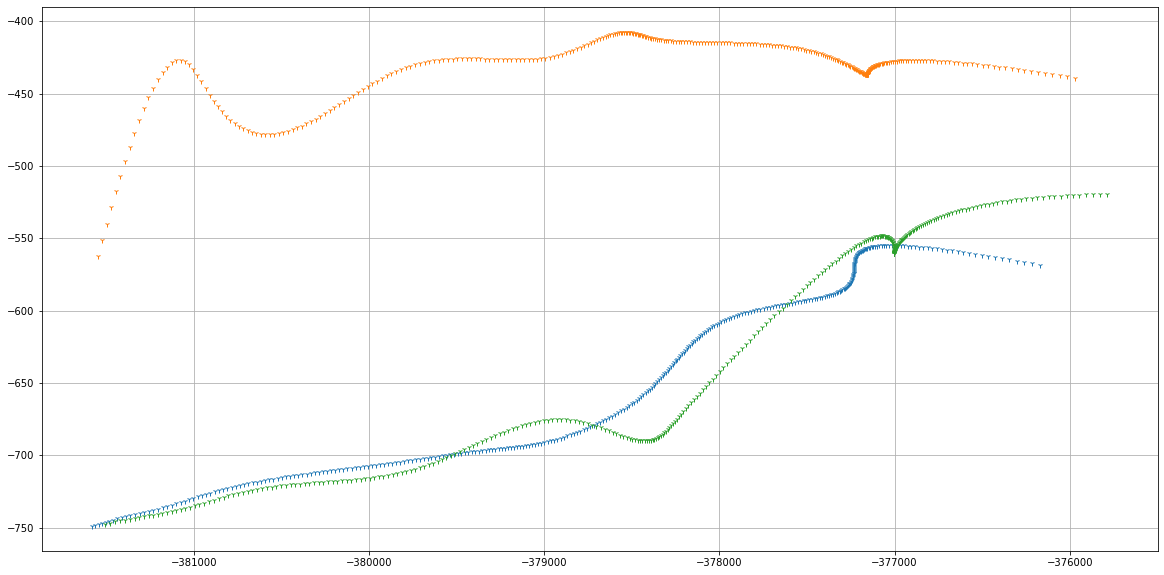

In [13]:
plt.figure(figsize=(20,10))
plt.plot(x_new[0,:],-it_new[0,:],'1')
plt.plot(x_new[10,:],-it_new[10,:],'1')
plt.plot(x_new[-1,:],-it_new[-1,:],'1')
# plt.plot(x,it,'x')
plt.grid()
plt.show()

## Midchan colored over bullseye

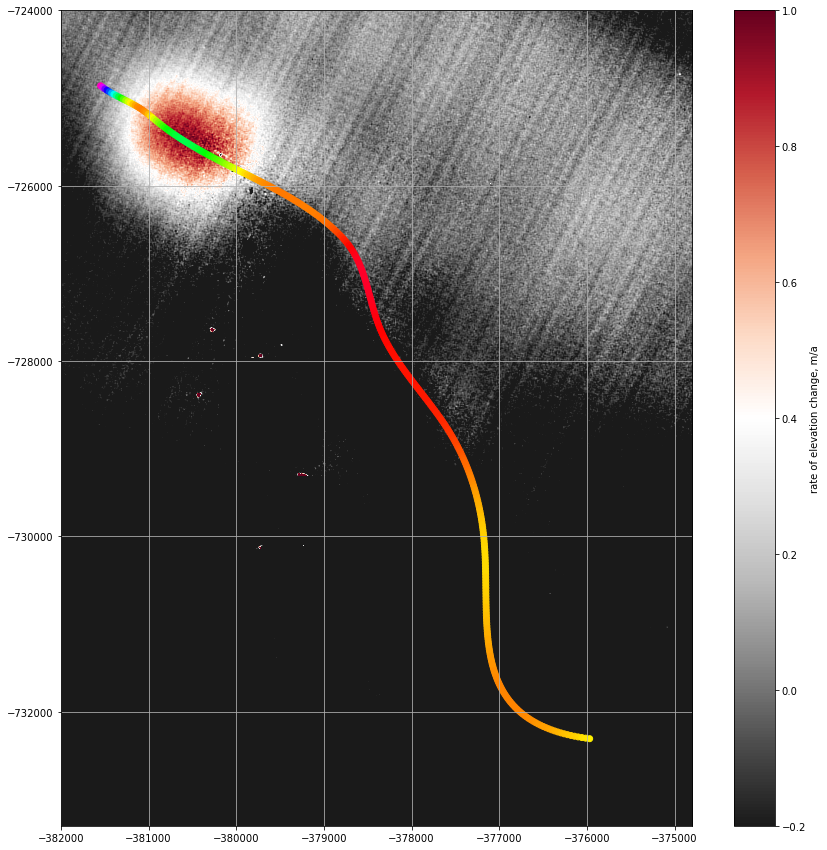

In [32]:
# %matplotlib qt
#rema
extent_REMA1 = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
plt.figure(figsize=(15,15))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent_REMAdiff, vmin=-0.2,vmax=1,cmap=GyRd)
cb = plt.colorbar()
cb.set_label('rate of elevation change, m/a')

plt.scatter(x_new[10,:],y_new[10,:],c=it_new[10,:],cmap='gist_rainbow')


plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/bullseye_n_basecontour.png')
# cb2 = plt.colorbar()
# cb2.set_label('Elevation of ice underside, m')
plt.xlim([-382000, -374800])
plt.ylim([-733300,-724000])
plt.grid()
plt.show()